<a href="https://colab.research.google.com/github/mbarbetti/unifi-physics-lab3/blob/main/Calibrazione_oscilloscopio_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calibrazione temporale dell'oscilloscopio
===
Lo scopo di questo programma è ricavare il fattore di conversione tra la misura del TDC in **unità aribitrarie** (*a.u.*) e i nanosecondi (*ns*). In aggiunta, il valore dell'intercetta ottenuto dal fit lineare permetterà di correggere le misure dei tempi da eventuali **errori sistematici** dovuti alla catena elettronica, all'oscilloscopio o a LabVIEW. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
## INSERIRE NUMERO DEL GRUPPO
group = "F2"   # esempio

In [18]:
from urllib.request import urlopen

data = urlopen (f"https://raw.githubusercontent.com/mbarbetti/unifi-physics-lab3/main/data/2021/data_{group}.txt")

for i, line in enumerate(data):
  print (line.decode('utf-8'))
  if i == 5: break

DATI MISURA



Inizio misura: 04/11/2021 17:13:56

Tempo di acquisizione (sec): 164273.7

Eventi acquisiti: 16030





Sfruttiamo il file di testo (".txt") per preparare un `DataFrame` Pandas, cioè una tabella organizzata per righe e colonne avente un set di funzioni utili per cercare, modificare, aggiungere o rimuovere elementi.

In [ ]:
file_path = f"https://raw.githubusercontent.com/mbarbetti/unifi-physics-lab3/main/data/2021/data_{group}.txt"
data = pd.read_csv (file_path, header = 4, delim_whitespace = True).drop([0])
data['QDC1'] = -data['QDC1'] * 1e9
data['QDC2'] = -data['QDC2'] * 1e9
data['TDC'] = data['TDC'] * 1e9
print(data)   # dataframe
print(min(data['QDC1'])," ",min(data['QDC1']))

                TDC      QDC1      QDC2
1      11101.228253  2.947916  2.933333
2       4192.008932  3.170833  3.179166
3       4960.750572  3.126041  3.050000
4       8414.093066  3.068750  3.013541
5       8797.889526  3.363541  3.323958
...             ...       ...       ...
16025    689.796501  4.576042  4.377084
16026   5918.349193  3.139583  3.135416
16027   8222.832015  3.279166  3.180208
16028   7068.929315  2.873958  2.878124
16029    162.846418  2.907291  2.898958

[16029 rows x 3 columns]
2.7177080000000005   2.7177080000000005


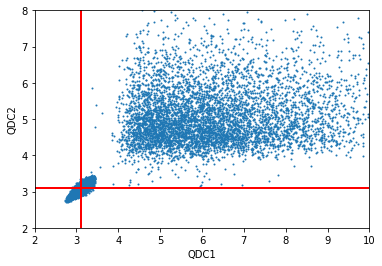

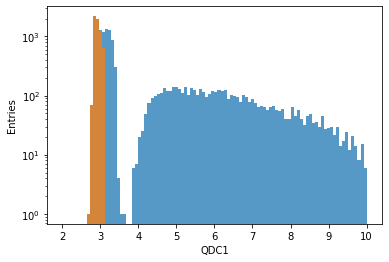

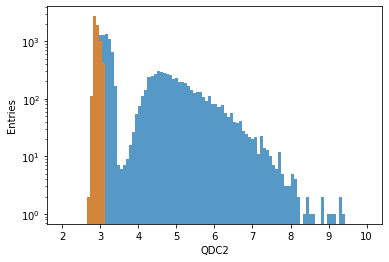

In [ ]:
# Plot calib values
qdc1_max = 3.1
qdc2_max = 3.1

data_calib = data.query (f"(QDC1 < {qdc1_max}) & (QDC2 < {qdc2_max})")
qdc1 = data_calib['QDC1']
qdc2 = data_calib['QDC2']
qdc1_all = data['QDC1']
qdc2_all = data['QDC2']

plt.xlabel ("QDC1")
plt.ylabel ("QDC2")
plt.plot ([0,10], [qdc2_max, qdc2_max], color = "red", lw = 2)
plt.plot ([qdc1_max, qdc1_max], [0,10], color = "red", lw = 2)
plt.scatter (qdc1_all, qdc2_all, s=1)
plt.axis ([2,10,2,8])
plt.show()

nbin = 100

plt.xlabel ("QDC1")
plt.ylabel ("Entries")
plt.hist (qdc1_all, bins=nbin, range = (2,10), alpha = 0.75, label='QDC1')
plt.hist (qdc1, bins=nbin, range = (2,10), alpha = 0.75, label='QDC1')
plt.yscale("log")
plt.show()

plt.xlabel ("QDC2")
plt.ylabel ("Entries")
plt.hist (qdc2_all, bins=nbin, range = (2,10), alpha = 0.75, label='QDC2')
plt.hist (qdc2, bins=nbin, range = (2,10), alpha = 0.75, label='QDC2')
plt.yscale("log")
plt.show()

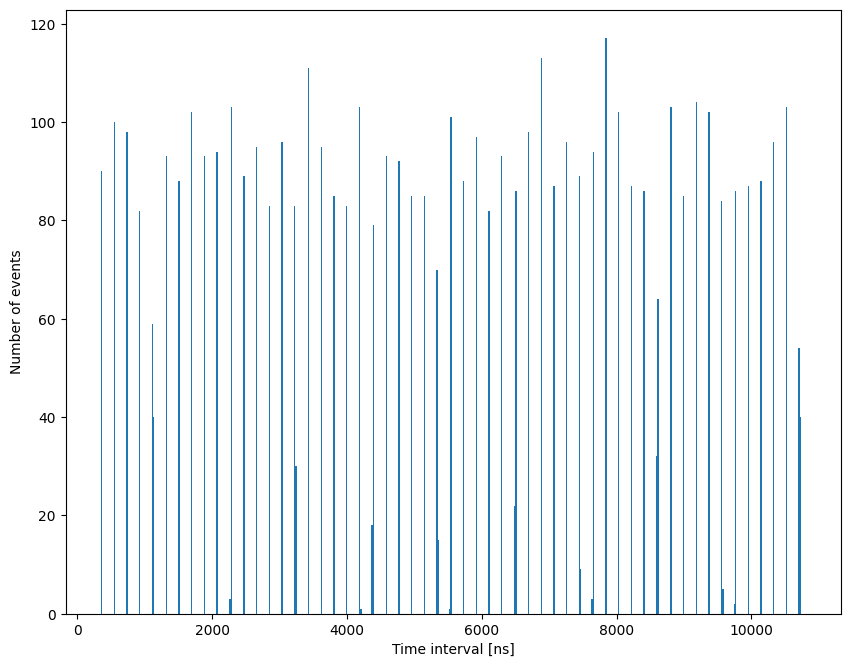

In [ ]:
### Prepare and fill histogram of time intervals
tdc = data_calib["TDC"].values

tmin = 350     # tdc.min()
tmax = 10800   # tdc.max()
nbins = 500

#print (np.histogram(tdc, bins = nbins, range = (tmin, tmax)))

plt.figure (figsize = (10,8), dpi = 100)
plt.xlabel('Time interval [ns]')
plt.ylabel('Number of events')
plt.hist (data_calib['TDC'], bins=nbins, range = (tmin, tmax), label='Measured time intervals')
plt.yscale("linear")
plt.show()

I tempi di riferimento per la calibrazione sono quelli prodotti dal **TIME CALIBRATOR**  che produce segnali di _start_ e _stop_ ogni 160 ns in una finestra temporale di circa 10 $\mu$s. Disponendo i tempi misurati dall'oscilloscopio in un istogramma, quello che ci aspettiamo di osservare è un "pettine" con 64 denti corrispondente ai 64 valori dei tempi accessibili dal TIME CALIBRATOR:

<center>$\mathcal{N}_{peaks} = \frac{\rm{finestra \, temporale}}{1/\rm{frequenza}} = \frac{10240 \, \rm{ns}}{160 \, \rm{ns}} = 64$</center>

In [ ]:
freq = 160   # time in ns
t_cal = np.arange (1,65) * freq
t_cal   # TIME CALIBRATOR values

array([  160,   320,   480,   640,   800,   960,  1120,  1280,  1440,
        1600,  1760,  1920,  2080,  2240,  2400,  2560,  2720,  2880,
        3040,  3200,  3360,  3520,  3680,  3840,  4000,  4160,  4320,
        4480,  4640,  4800,  4960,  5120,  5280,  5440,  5600,  5760,
        5920,  6080,  6240,  6400,  6560,  6720,  6880,  7040,  7200,
        7360,  7520,  7680,  7840,  8000,  8160,  8320,  8480,  8640,
        8800,  8960,  9120,  9280,  9440,  9600,  9760,  9920, 10080,
       10240])

La cella di codice sottostante permette di _fittare_ con una gaussiana un singolo picco contenuto nel "pettine".  
La funzione `gauss_fit` richiede i seguenti attributi:
* `sample`: un campione di misure dei tempi relativo a uno specifico picco;
* `bins`: numero di bins per costruire l'istogramma su cui fare il fit gaussiano;
* `range`: intervallo di valori scelto per l'istogramma su cui fare il fit gaussiano;
* `plot`: variabile booleana per abilitare (`True`) o meno (`False`) il plot del fit.

In [ ]:
from scipy.optimize import curve_fit

def gauss (x, mean, sigma, N):
  return (N / np.sqrt (2 * np.pi * sigma**2)) * np.exp (-0.5 * (x - mean)**2 / sigma**2)

def gauss_fit (sample, bins, range, plot = False):
  weights = np.ones_like (sample) / len (sample)
  entries, bin_edges = np.histogram (sample, bins = bins, range = range, weights = weights)
  #tot_entries = np.sum (entries)
  #print (tot_entries)

  bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
  min_bin = bin_centers.min()
  max_bin = bin_centers.max()
  width = max_bin - min_bin

  popt, pcov = curve_fit (gauss, bin_centers, entries, bounds = ([min_bin, 0.1*width, 0.], [max_bin, width, 1.]))
  perr = np.sqrt (np.diag (pcov))

  if plot:
    plt.figure (figsize = (8,5))
    plt.title ('Fit plot', fontsize = 14)
    plt.xlabel ('ADC counts [a.u.]', fontsize = 12)
    plt.ylabel ('Normalized entries', fontsize = 12)
    plt.hist (sample, bins = bins, range = range, weights = weights, color = 'royalblue', label = 'Data')
    plt.plot (bin_centers, gauss (bin_centers, popt[0], popt[1], popt[2]), color = 'red', linewidth = 2, label = 'Fit result')
    plt.legend (loc = 'upper left', fontsize = 10)
    plt.show()

  return popt, perr

La funzione `peak_study` permette di estrarre **sotto-campioni** di tempi misurati a partire dai dati contenuti in "Dati_calibrazione.txt". Per far ciò, preso un valore di tempo _nominale_ `time_val` (multiplo di 160 ns), la cella di codice sottostante estrae un sotto-campione centrato in `time_val` e largo $2 \, \times$ `bound` dal dataset originale. Il campione così ottenuto viene quindi utilizzato per **caratterizzare** il picco. Se la _flag_ booleana `fit` è vera, allora il sotto-campione viene passato alla funzione `gauss_fit` che ne calcola centroide e deviazione standard (con relativi errori dovuti al fit). Se invece la flag booleana `fit` è falsa, allora `peak_study` ha come output la media e la deviazione standard dei valori contenuti nel sotto-campione.

In [ ]:
def peak_study (sample, time_val, bound, plot = False, fit = True):
  mask = (sample > (time_val - bound)) & (sample < (time_val + bound))
  sub_sample = sample [mask]
  #print(sub_sample)

  min_val = sub_sample.min()
  max_val = sub_sample.max()
  width = max_val - min_val
  #print(min_val, max_val, width)

  bins  = 50
  _range = [min_val - 0.5 * width, max_val + 0.5 * width]

  if plot and not fit:
    print ('\n----- DATA PLOT -----')
    plt.figure (figsize = (8,5))
    plt.title  ('Time distribution', fontsize = 14)
    plt.xlabel ('Measured time', fontsize = 12)
    plt.ylabel ('Entries', fontsize = 12)
    plt.hist (sub_sample, bins = bins, range = _range, color = 'royalblue')
    plt.yscale("log")
    plt.show()

  if fit and plot:
    if plot: print ('\n----- FIT PLOT -----')
    results, errs = gauss_fit (sub_sample, bins, _range, plot = plot)
    mean, sigma, N = results
    mean_err, sigma_err, N_err = errs
  elif not fit:
    mean = np.mean (sub_sample)
    mean_err = 0.
    sigma = np.std (sub_sample)
    sigma_err = 0.

  mean_fit  = [mean, mean_err]
  sigma_fit = [sigma, sigma_err]
  return mean_fit, sigma_fit

Attivando la _flag_ booleana `plot` è possibile visualizzare il dataset preso in analisi con sovrapposta la curva gaussiana ottenuta dal fit.

In [ ]:
#mean, std = peak_study (tdc, time_val = 160, bound = 10, plot = True, fit = True)
#print ('mean = {:.5f} +/- {:.5f}' . format (mean[0], mean[1]))
#print (' std = {:.5f} +/- {:.5f}' . format ( std[0],  std[1]))
#
#### Prepare and fill histogram of time intervals
#delta_t = 0.1 
#tmin = 1585
#tmax = 1620
#nmin = int(tmin/delta_t) 
#nmax = int(tmax/delta_t) 
#bins = nmax - nmin 
#_range = [tmin, tmax]
#plt.hist (tdc, bins = bins, range = _range, color = 'royalblue')
#plt.yscale("log")
#plt.show()

Inserendo la funzione `peak_study` all'interno di un ciclo `for` che corra su tutti i valori accessibili al TIME CALIBRATOR è possibile ottenere tutti i **centroidi** dei picchi che formano il "pettine".


----- FIT PLOT -----


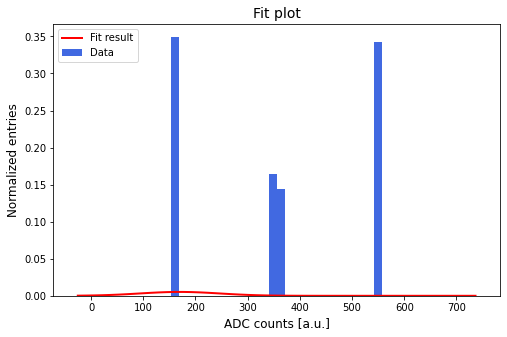


----- FIT PLOT -----


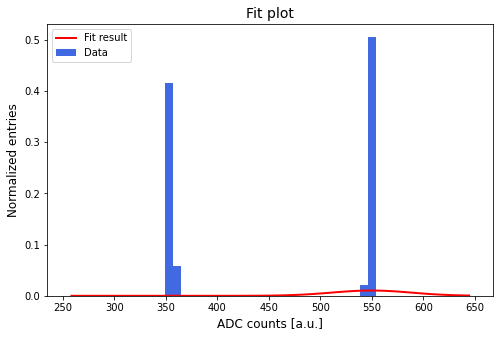


----- FIT PLOT -----


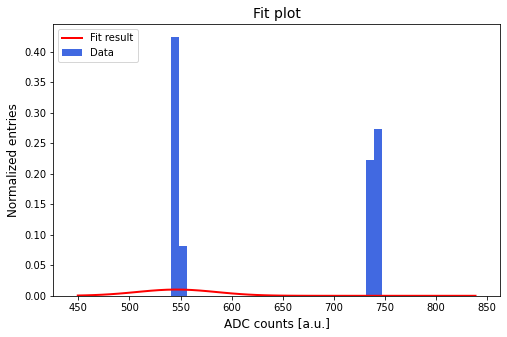


----- FIT PLOT -----


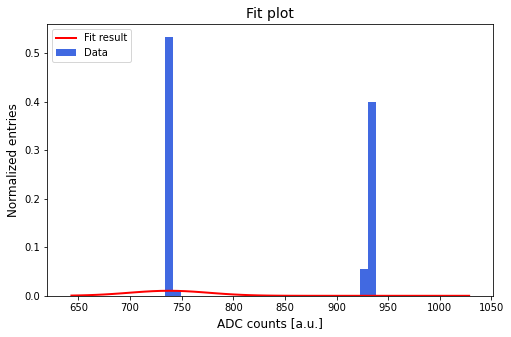


----- FIT PLOT -----


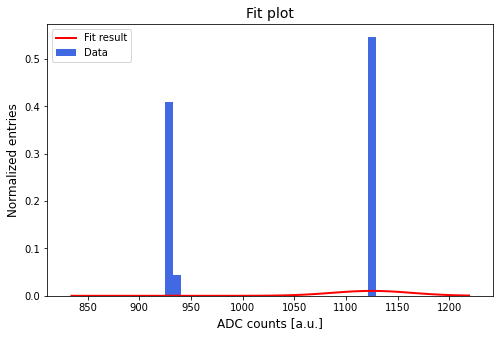


----- FIT PLOT -----


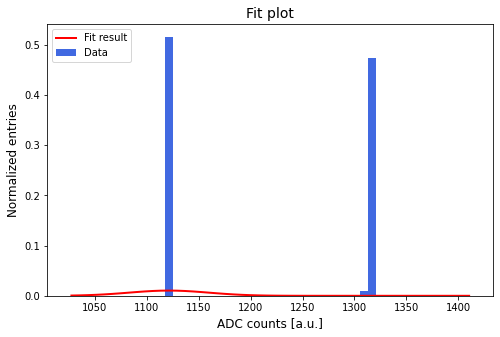


----- FIT PLOT -----


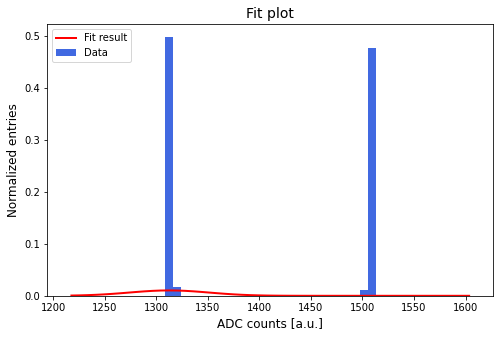


----- FIT PLOT -----


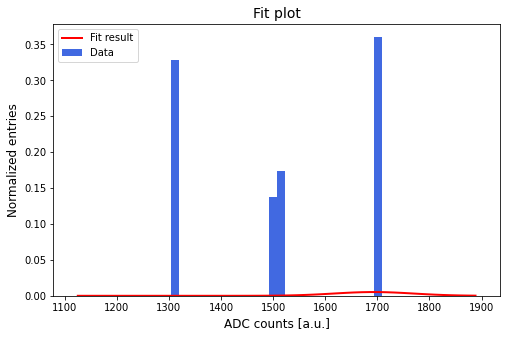


----- FIT PLOT -----


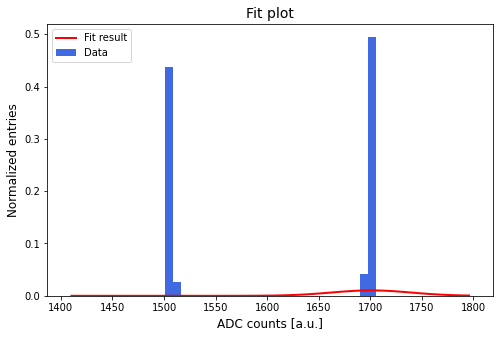


----- FIT PLOT -----


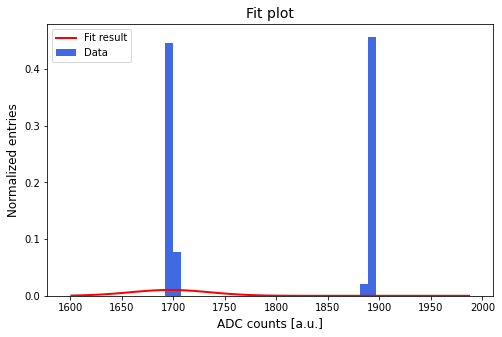


----- FIT PLOT -----


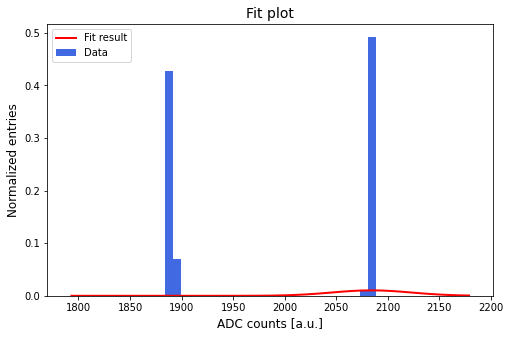


----- FIT PLOT -----


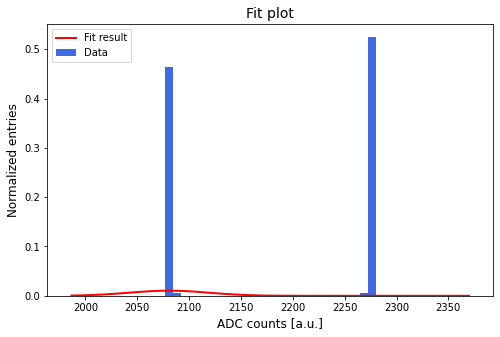


----- FIT PLOT -----


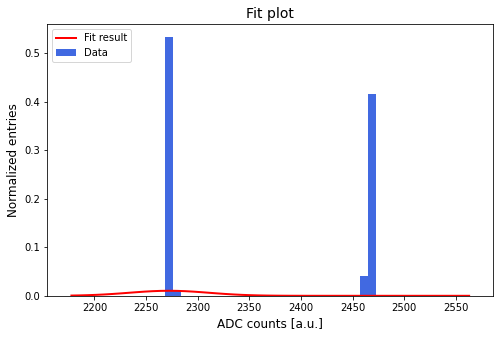


----- FIT PLOT -----


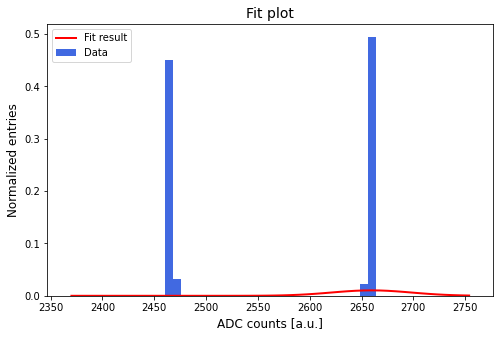


----- FIT PLOT -----


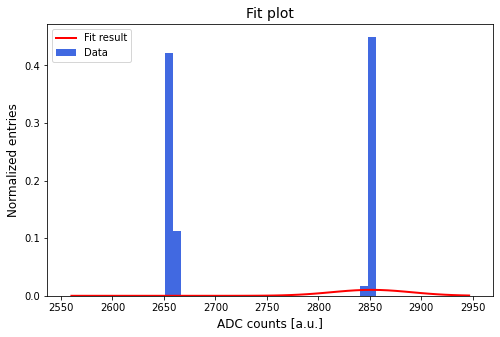


----- FIT PLOT -----


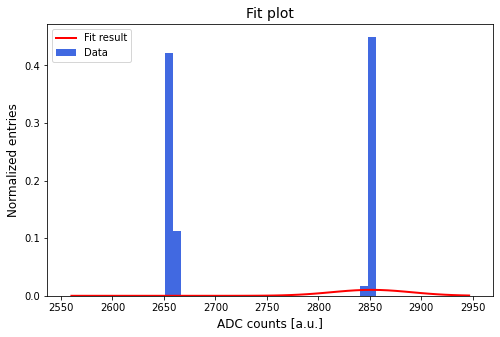


----- FIT PLOT -----


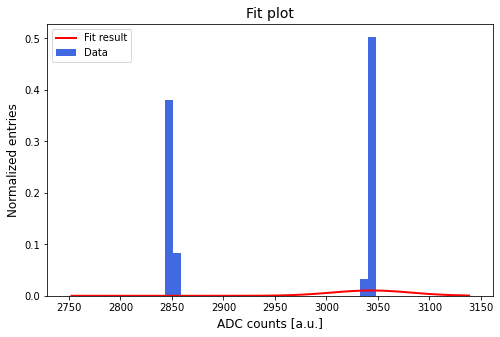


----- FIT PLOT -----


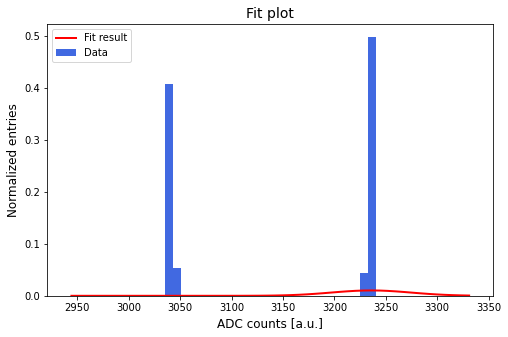


----- FIT PLOT -----


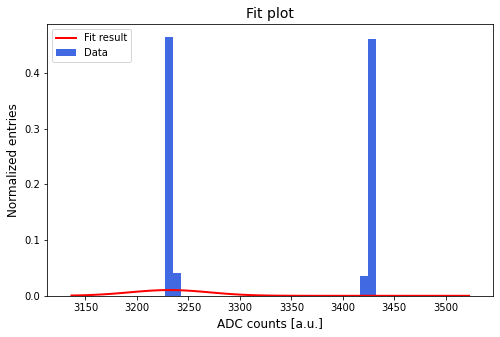


----- FIT PLOT -----


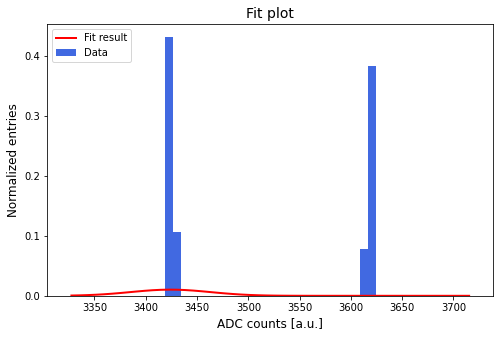


----- FIT PLOT -----


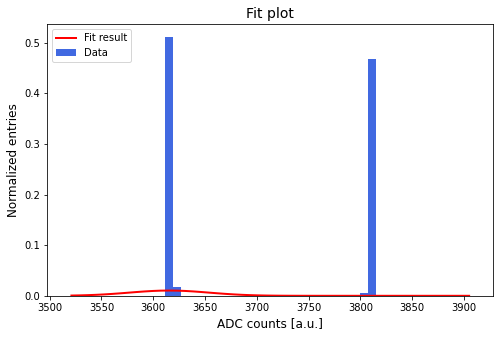


----- FIT PLOT -----


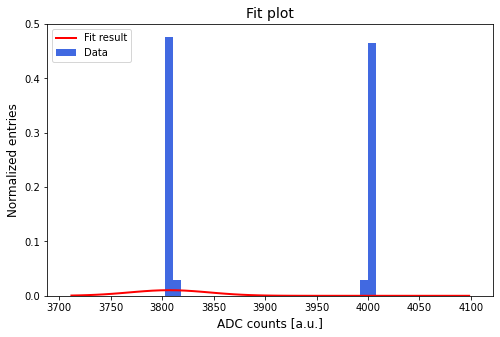


----- FIT PLOT -----


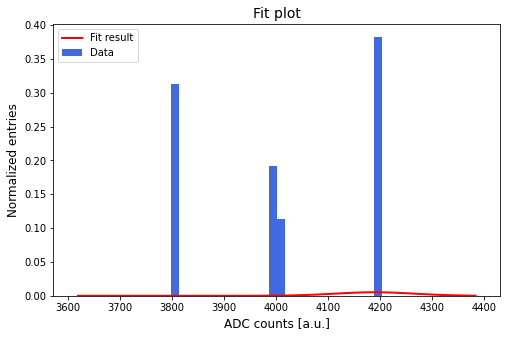


----- FIT PLOT -----


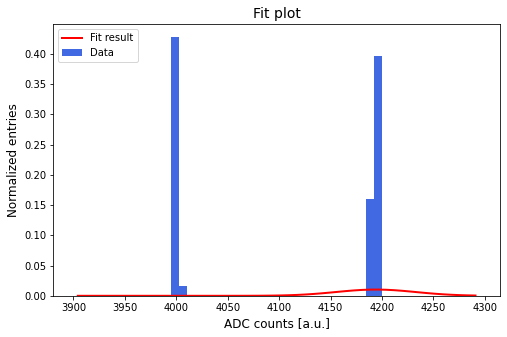


----- FIT PLOT -----


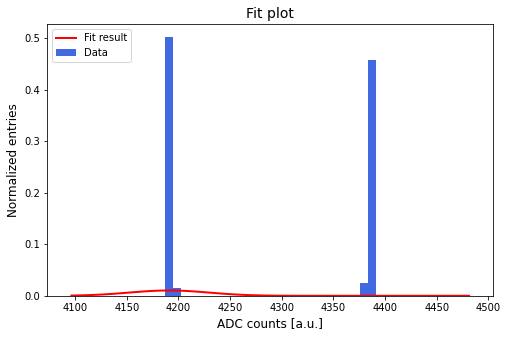


----- FIT PLOT -----


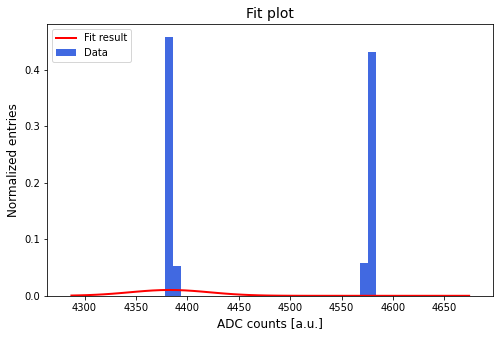


----- FIT PLOT -----


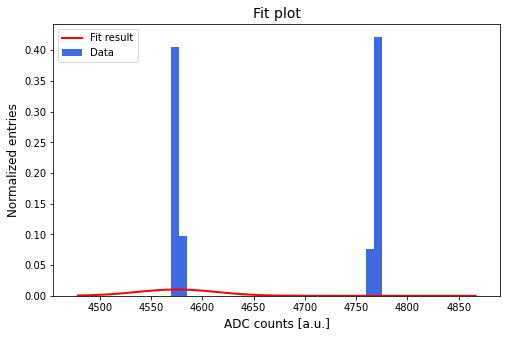


----- FIT PLOT -----


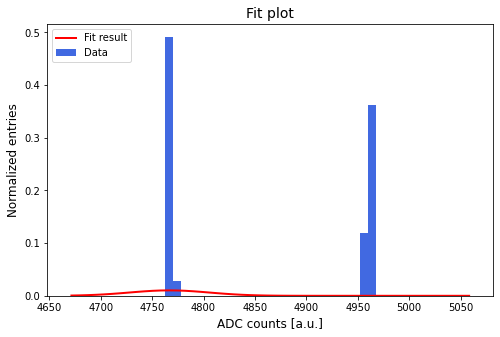


----- FIT PLOT -----


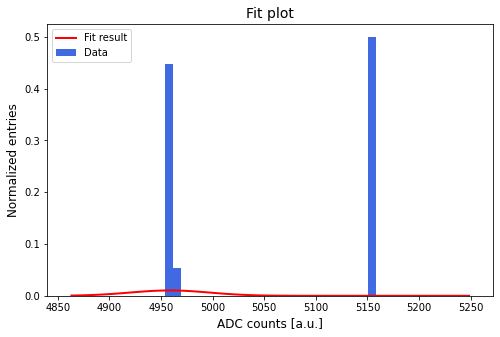


----- FIT PLOT -----


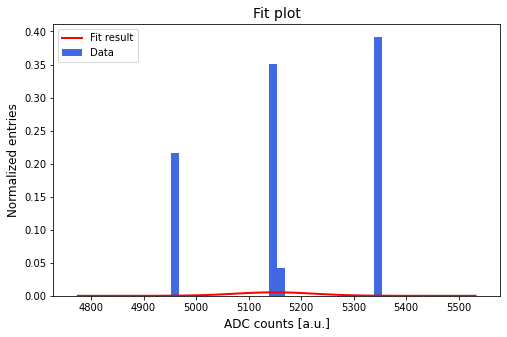


----- FIT PLOT -----


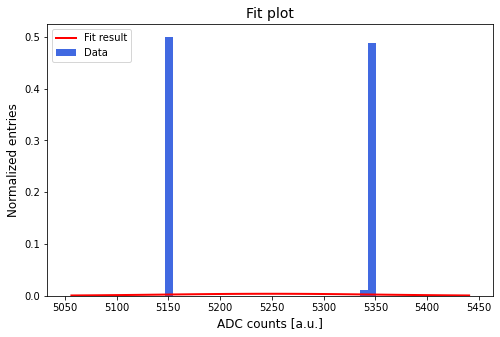


----- FIT PLOT -----


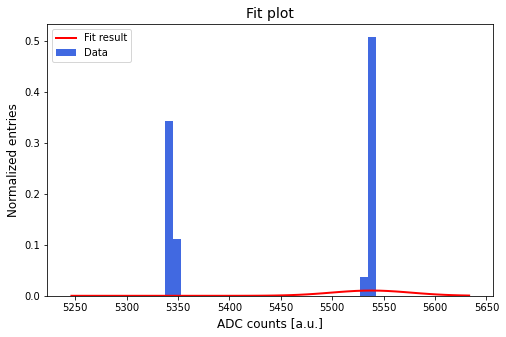


----- FIT PLOT -----


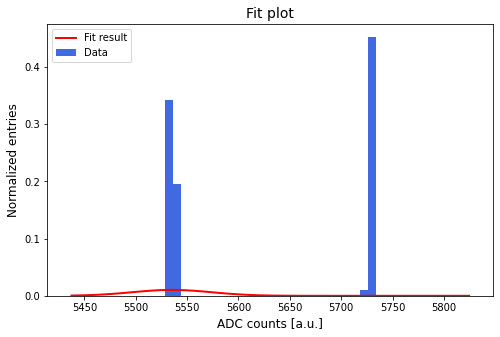


----- FIT PLOT -----


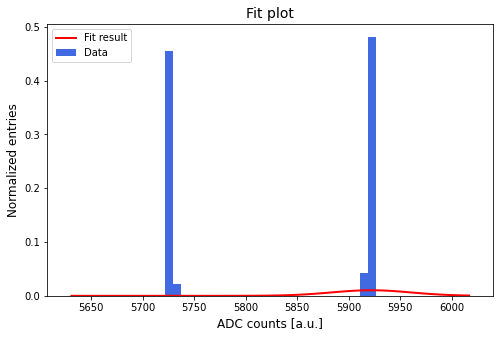


----- FIT PLOT -----


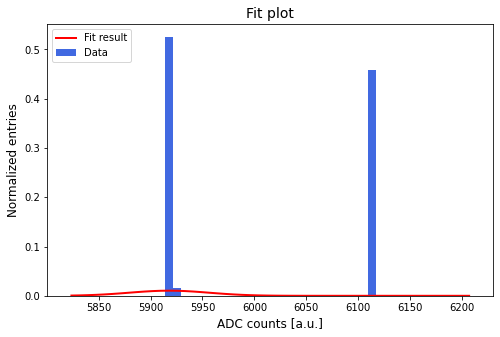


----- FIT PLOT -----


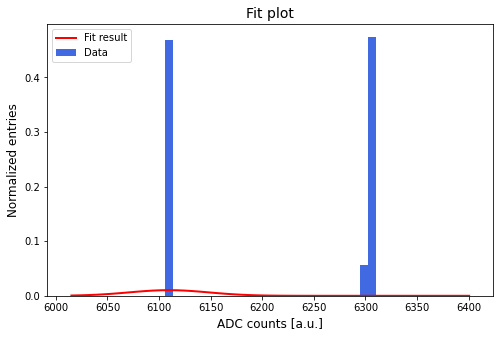


----- FIT PLOT -----


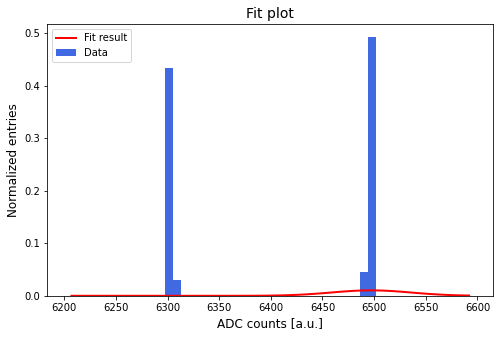


----- FIT PLOT -----


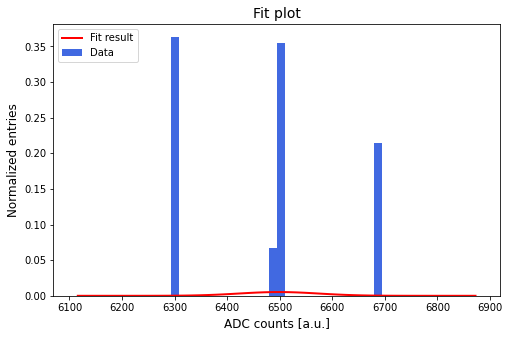


----- FIT PLOT -----


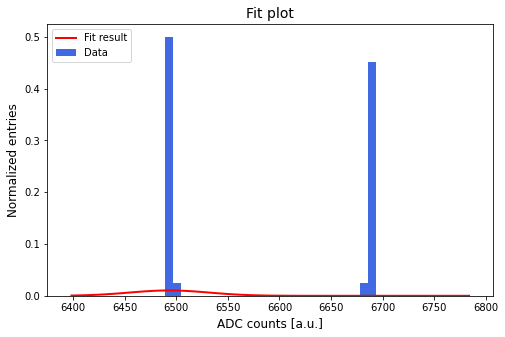


----- FIT PLOT -----


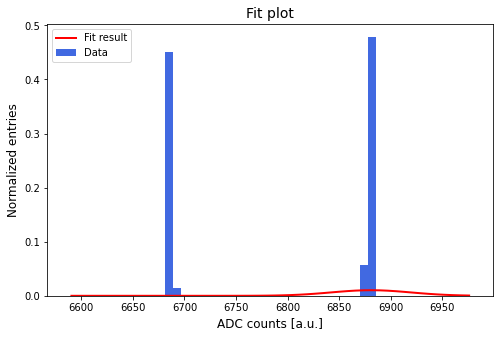


----- FIT PLOT -----


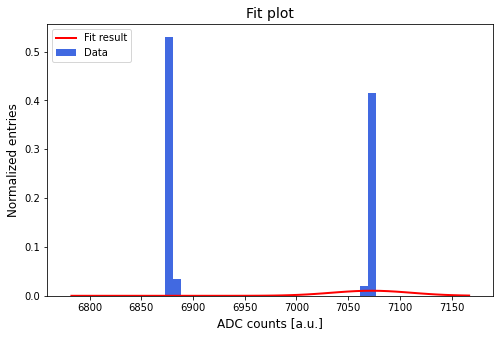


----- FIT PLOT -----


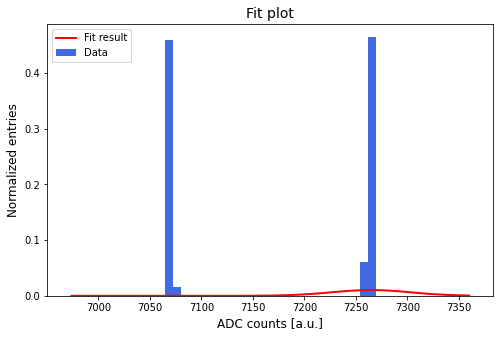


----- FIT PLOT -----


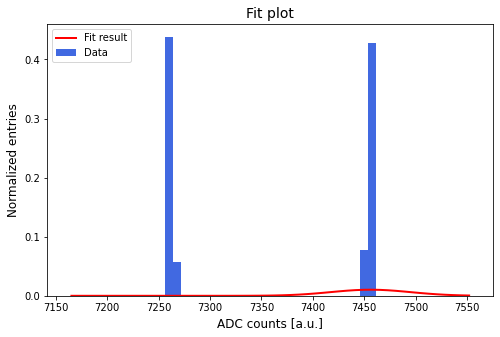


----- FIT PLOT -----


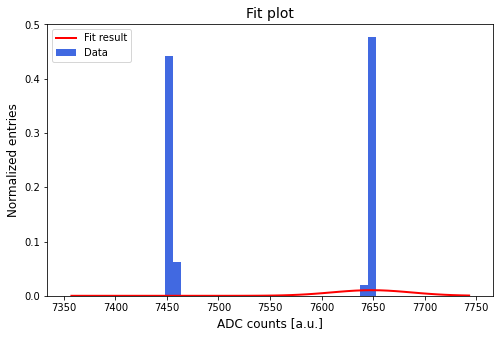


----- FIT PLOT -----


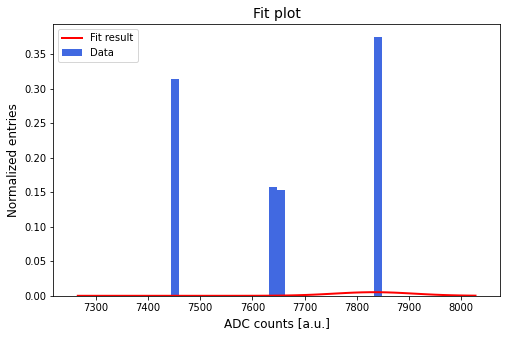


----- FIT PLOT -----


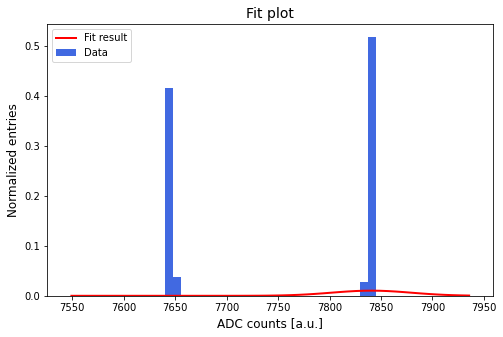


----- FIT PLOT -----


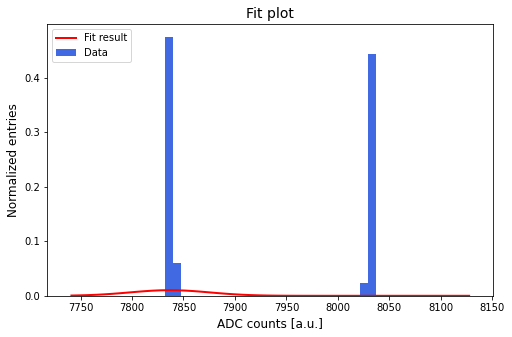


----- FIT PLOT -----


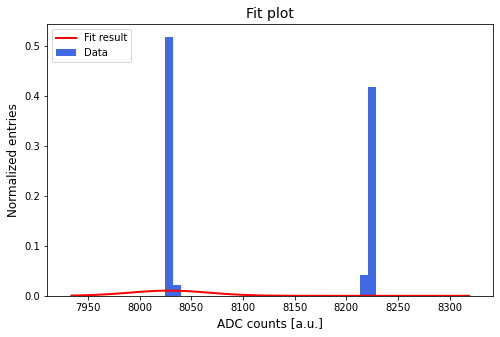


----- FIT PLOT -----


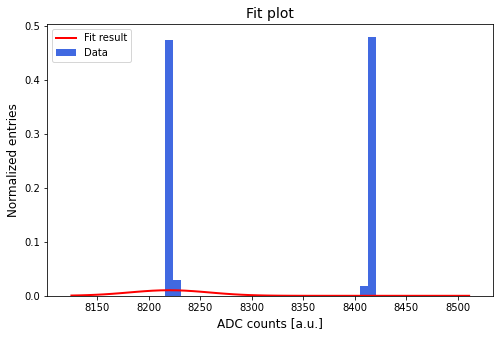


----- FIT PLOT -----


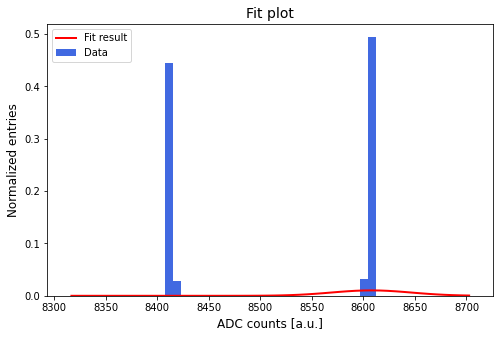


----- FIT PLOT -----


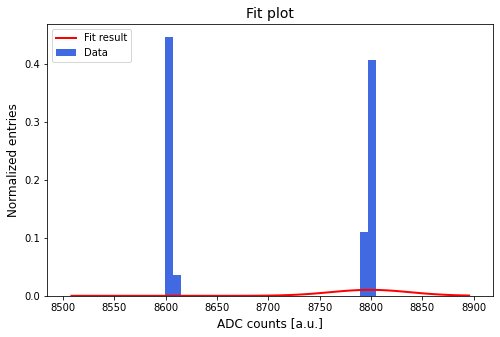


----- FIT PLOT -----


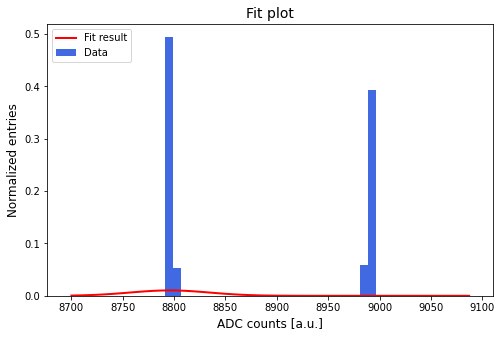


----- FIT PLOT -----


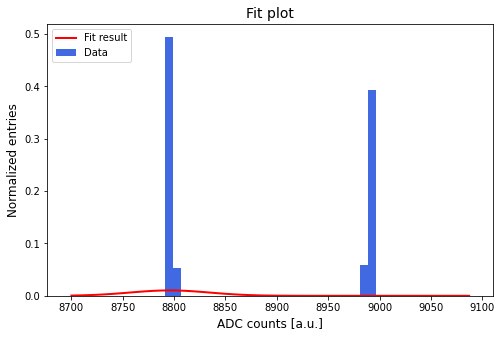


----- FIT PLOT -----


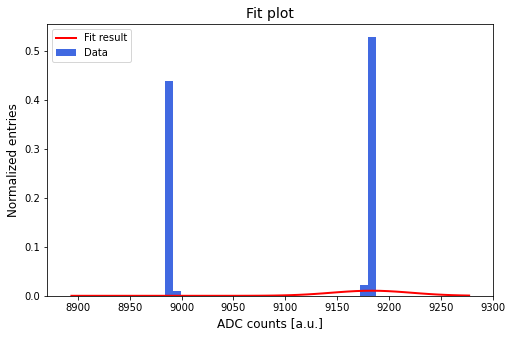


----- FIT PLOT -----


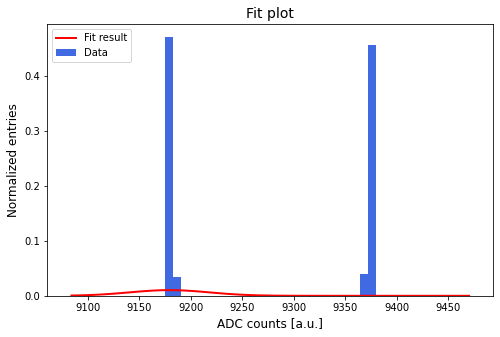


----- FIT PLOT -----


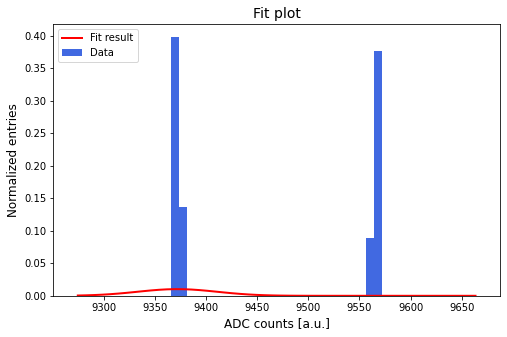


----- FIT PLOT -----


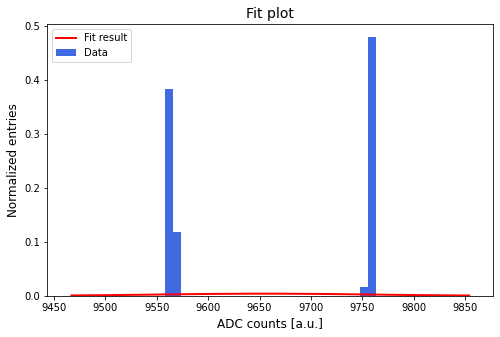


----- FIT PLOT -----


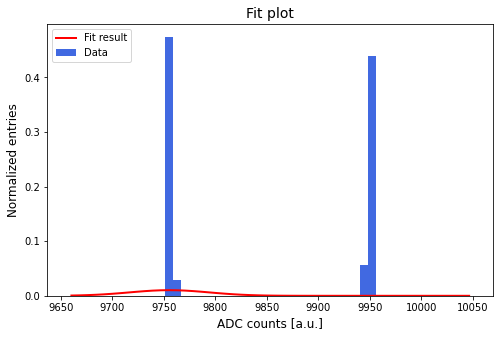


----- FIT PLOT -----


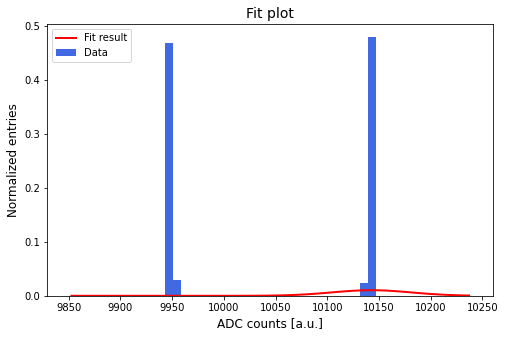


----- FIT PLOT -----


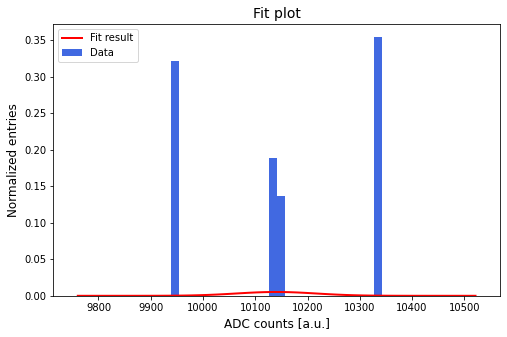


----- FIT PLOT -----


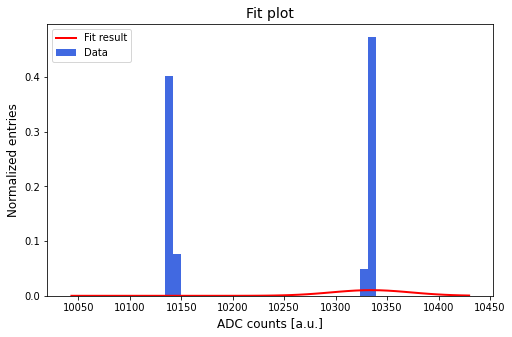


----- FIT PLOT -----


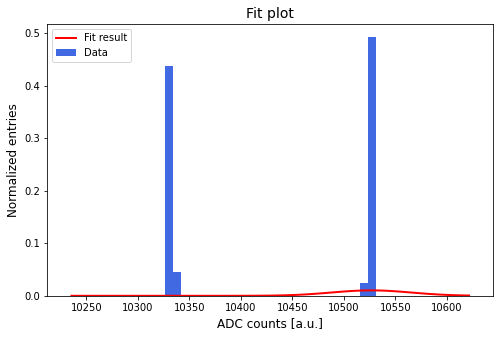


----- FIT PLOT -----


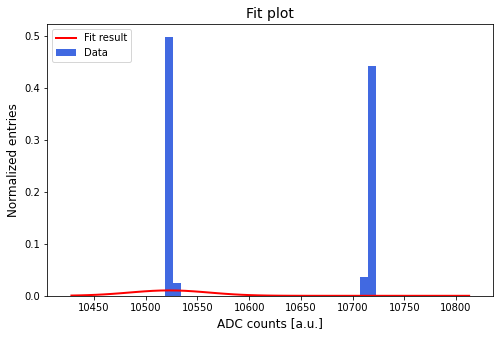


----- FIT PLOT -----


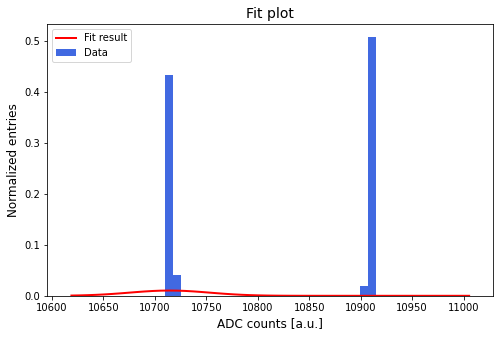

,Times,ADC counts,Uncertainties
0,160.0,169.921276,542.505489
1,320.0,549.617066,170.360402
2,480.0,546.011414,145.882861
3,640.0,737.711337,172.358284
4,800.0,1125.017052,176.018487
...,...,...,...
59,9600.0,10140.012542,537.041920
60,9760.0,10334.373353,162.420621
61,9920.0,10526.603733,170.783995
62,10080.0,10522.665845,171.227694


In [ ]:
t_mis = list()
errs  = list()

times = np.linspace (tmin, tmax, len(t_cal))
#print (times)

for t in times:
  mean, std = peak_study (tdc, t, 200, plot = True, fit = True)
  t_mis . append (mean[0])
  #errs  . append (std[0])
  errs . append (mean[1])

df = pd.DataFrame (np.c_ [t_cal, t_mis, errs], columns = ['Times', 'ADC counts', 'Uncertainties'])
df

A questo punto abbiamo tutto il necessario per procedere con il **fit lineare**!

In [ ]:
ones = np.ones_like (t_cal)

X = np.c_ [t_cal, ones]
V = np.diag (np.square (errs))
V_inv = np.linalg.inv (V)

theta = np.linalg.inv (X.T @ V_inv @ X) @ X.T @ V_inv @ t_mis
print ('Results from least square fit:')
print (f'    Slope = {theta[0]:.5f} a.u./ns')
print (f'    Intercept = {theta[1]:.5f} a.u.')

Results from least square fit:
    Slope = 1.03848 a.u./ns
    Intercept = 165.12798 a.u.


Verifichiamo la bontà del fit *plottando* i risultati ottenuti!

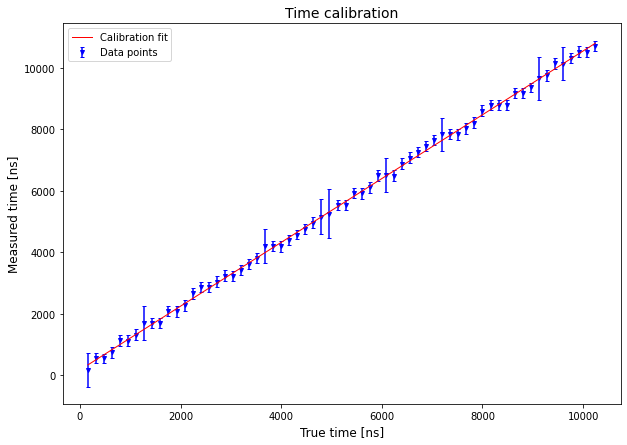

In [ ]:
plt.figure (figsize = (10, 7))
plt.title ('Time calibration', fontsize = 14)
plt.xlabel ('True time [ns]', fontsize = 12)
plt.ylabel ('Measured time [ns]', fontsize = 12)

t_fit = theta[0] * t_cal + theta[1]

plt.errorbar (t_cal, t_mis, yerr = errs, color = 'blue', fmt = 'v',
              markersize = 4, barsabove = True, capsize = 2, label = 'Data points')
plt.plot (t_cal, t_fit, color = 'red', linewidth = 1, label = 'Calibration fit')

plt.legend (loc = 'upper left', fontsize = 10)
plt.show()

L'ampia finestra considerata per i tempi non permette di apprezzare eventuali _disaccordi_ con quanto ottenuto dal fit. Per evidenziarli, riportiamo su grafico i cosiddetti **residui**:

<center>$\rm{residuals} = y_{\rm{true}} - y_{\rm{fit}}$</center>

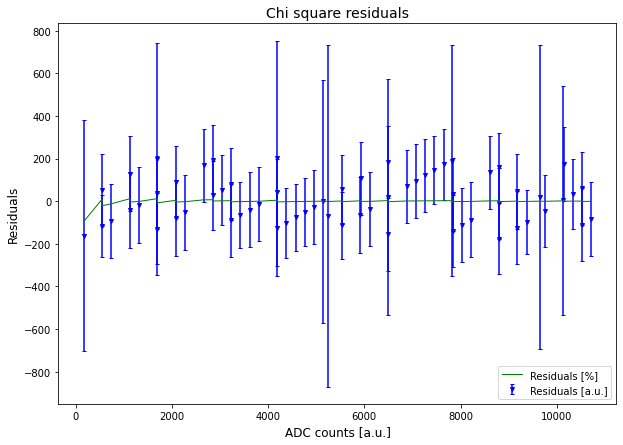

In [ ]:
plt.figure (figsize = (10, 7))
plt.title ('Chi square residuals', fontsize = 14)
plt.xlabel ('ADC counts [a.u.]', fontsize = 12)
plt.ylabel ('Residuals', fontsize = 12)

residuals = t_mis - t_fit

plt.errorbar (t_mis, residuals, yerr = errs, color = 'blue', fmt = 'v',
              markersize = 4, barsabove = True, capsize = 2, label = 'Residuals [a.u.]')
plt.plot (t_mis, 100 * residuals / np.array(t_mis), color = 'green', 
          linewidth = 1, label = 'Residuals [%]')

plt.legend (loc = 'lower right', fontsize = 10)
plt.show()

Quindi, sfruttando la libreria `stats` di SciPy, calcoliamo il $\chi^2$ associato al fit:

In [ ]:
from scipy.stats import chi2

squares  = np.square (residuals/errs)
chi2_fit = np.sum (squares)
ndf = squares.size - 2
p_val = 1 - chi2.cdf (chi2_fit, ndf)

print ('Results from least square fit:')
print (f'    Slope = {theta[0]:.5f} a.u./ns')
print (f'    Intercept = {theta[1]:.5f} a.u.')
print (f'    chi2 = {chi2_fit:.3f}')
print (f'    ndf  = {ndf:.3f}')
print (f'    p-value = {100*p_val:.1f}%')

Results from least square fit:
    Slope = 1.03848 a.u./ns
    Intercept = 165.12798 a.u.
    chi2 = 21.028
    ndf  = 62.000
    p-value = 100.0%


Infine, siamo in grado di calcolare il **fattore di conversione** da unità arbitrarie a nanosecondi, così come siamo in grado di **correggere** le misure dei tempi per tener conto del contributo sistematico introdotto dalla catena di misura.

In [ ]:
conv_factor = 1 / theta[0]
corr_factor = - theta[1] * conv_factor   #errore? 

print ('Results for muon lifetime study:')
print ('    conversion factor = {:.5f} ns/a.u.' . format (conv_factor))
print ('    correction factor = {:.5f} ns' . format (corr_factor))

print ('\nt_corr = ({:.5f}) * t_mis + ({:.5f}) ns' . format (conv_factor, corr_factor))

Results for muon lifetime study:
    conversion factor = 0.96295 ns/a.u.
    correction factor = -159.00977 ns

t_corr = (0.96295) * t_mis + (-159.00977) ns
